## Description:
这个jupyter是建立Deep Crossing模型并完成训练， 这个模型结构相对来说比较简单， 我们可以看一下结构：

![](img/1.png)
下面尝试用Pytorch建立这个模型， 并使用Pytorch完成模型的训练和测试， 一方面对这个结构有个更深的认识， 另一方面也可以把Pytorch的知识应用起来。关于Pytorch的建模流程， 主要有四步：
1. 准备数据
2. 建立模型
3. 训练模型
4. 使用和保存

基于之前学习的Pytorch知识， 利用这个机会把这些都串一下。 

## 导入包和数据

In [16]:
import datetime
import numpy as np
import pandas as pd

import torch 
from torch.utils.data import TensorDataset, Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary, Model

from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [17]:
# 导入数据， 数据已经处理好了 preprocess/下
train_set = pd.read_csv('preprocessed_data/train_set.csv')
val_set = pd.read_csv('preprocessed_data/val_set.csv')
test_set = pd.read_csv('preprocessed_data/test.csv')

In [18]:
val_set.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.000000,0.000127,0.000000,0.000000,0.017115,0.000000,0.000000,0.000000,0.000000,0.00,...,463,23,2,554,0,0,539,27,49,0
1,0.000000,0.000127,0.002010,0.045977,0.000608,0.012290,0.000000,0.007313,0.000710,0.00,...,263,20,2,407,0,1,635,1,206,0
2,0.031579,0.016145,0.001182,0.114943,0.000002,0.001078,0.008444,0.010969,0.002129,0.25,...,188,115,3,971,0,7,567,27,465,1
3,0.000000,0.021485,0.000000,0.000000,0.000195,0.052178,0.003619,0.001828,0.001597,0.00,...,387,0,0,2,0,3,163,0,0,0
4,0.000000,0.000127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,233,0,0,66,0,0,44,0,0,0


In [19]:
# 这里需要把特征分成数值型和离散型， 因为后面的模型里面离散型的特征需要embedding， 而数值型的特征直接进入了stacking层， 处理方式会不一样
data_df = pd.concat((train_set, val_set, test_set))

dense_feas = ['I'+str(i) for i in range(1, 14)]
sparse_feas = ['C'+str(i) for i in range(1, 27)]

# 定义一个稀疏特征的embedding映射， 字典{key: value}, key表示每个稀疏特征， value表示数据集data_df对应列的不同取值个数， 作为embedding输入维度
sparse_feas_map = {}
for key in sparse_feas:
    sparse_feas_map[key] = data_df[key].nunique()

In [20]:
feature_info = [dense_feas, sparse_feas, sparse_feas_map]  # 这里把特征信息进行封装， 建立模型的时候作为参数传入

In [21]:
train_set.columns
test_set.columns

Index(['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
       'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'],
      dtype='object')

## 准备数据

In [22]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(train_set.drop(columns='Label').values).float(), torch.tensor(train_set['Label'].values).float())
dl_val_dataset = TensorDataset(torch.tensor(val_set.drop(columns='Label').values).float(), torch.tensor(val_set['Label'].values).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_vaild = DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

## 建立模型
常用的三种方式
1. 继承nn.Module基类构建自定义模型
2. nn.Sequential按层顺序构建模型
3. 继承nn.Module基类构建模型， 并辅助应用模型容器进行封装

这里我们使用第三种方式搭建DeepCrossing模型， 因为这里的embedding层需要多种

![](img/1.png)

In [23]:
# 首先， 自定义一个残差块
class Residual_block(nn.Module):
    """
    Define Residual_block
    """
    def __init__(self, hidden_unit, dim_stack):
        super(Residual_block, self).__init__()
        self.linear1 = nn.Linear(dim_stack, hidden_unit)
        self.linear2 = nn.Linear(hidden_unit, dim_stack)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        orig_x = x.clone()
        x = self.linear1(x)
        x = self.linear2(x)
        outputs = self.relu(x + orig_x)
        return outputs

In [24]:
# 定义deep Crossing 网络
class DeepCrossing(nn.Module):
    
    def __init__(self, feature_info, hidden_units, dropout=0., embed_dim=10, output_dim=1):
        """
        DeepCrossing：
            feature_info: 特征信息（数值特征， 类别特征， 类别特征embedding映射)
            hidden_units: 列表， 隐藏单元的个数(多层残差那里的)
            dropout: Dropout层的失活比例
            embed_dim: embedding维度
        """
        super(DeepCrossing, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        
        # embedding层， 这里需要一个列表的形式， 因为每个类别特征都需要embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(key): nn.Embedding(num_embeddings=val, embedding_dim=embed_dim)
            for key, val in self.sparse_feas_map.items()
        })
        
        # 统计embedding_dim的总维度
        embed_dim_sum = sum([embed_dim]*len(self.sparse_feas))
        
        # stack layers的总维度
        dim_stack = len(self.dense_feas) + embed_dim_sum
        
        # 残差层
        self.res_layers = nn.ModuleList([
            Residual_block(unit, dim_stack) for unit in hidden_units
        ])
        
        # dropout层
        self.res_dropout = nn.Dropout(dropout)
        
        # 线性层
        self.linear = nn.Linear(dim_stack, output_dim)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :13], x[:, 13:]
        sparse_inputs = sparse_inputs.long()      # 需要转成长张量， 这个是embedding的输入要求格式
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:, i]) for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]   
        sparse_embed = torch.cat(sparse_embeds, axis=-1)
        stack = torch.cat([sparse_embed, dense_inputs], axis=-1)
        r = stack
        for res in self.res_layers:
            r = res(r)
        
        r = self.res_dropout(r)
        outputs = F.sigmoid(self.linear(r))
        return outputs

In [25]:
hidden_units = [256, 128, 64, 32]
net = DeepCrossing(feature_info, hidden_units)
summary(net, input_shape=(train_set.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 10]             790
         Embedding-2                   [-1, 10]           2,520
         Embedding-3                   [-1, 10]          12,930
         Embedding-4                   [-1, 10]          10,430
         Embedding-5                   [-1, 10]             300
         Embedding-6                   [-1, 10]              70
         Embedding-7                   [-1, 10]          11,640
         Embedding-8                   [-1, 10]             390
         Embedding-9                   [-1, 10]              20
        Embedding-10                   [-1, 10]           9,080
        Embedding-11                   [-1, 10]           9,260
        Embedding-12                   [-1, 10]          12,390
        Embedding-13                   [-1, 10]           8,240
        Embedding-14                   

In [26]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = net(fea)
    print(out)
    break

tensor([[0.5178],
        [0.4325],
        [0.4382],
        [0.3304],
        [0.4451],
        [0.3867],
        [0.3748],
        [0.3661],
        [0.4112],
        [0.5896],
        [0.4178],
        [0.4421],
        [0.3841],
        [0.4920],
        [0.4418],
        [0.4571]], grad_fn=<SigmoidBackward0>)


## 模型的训练
模型的训练一般会有三种风格， 由于计算AUC的时候， 只有一类会报错， 这里训练的时候得处理一下， 所以采用脚本的训练风格以方便处理， 但是在训练之前， 先把训练的相关设置定义好， 包括评估指标， 损失函数和优化方法等

In [27]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)     # 计算AUC， 但要注意如果y只有一个类别的时候， 会报错

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

### 脚本训练方式 

In [28]:
epochs = 4
log_step_freq = 10

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in range(1, epochs+1):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = net(features)
        # Reshape labels to match predictions shape
        labels = labels.view(-1, 1)
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            continue
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric # metric_func already returns a float, no need for .item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_vaild, 1):
        with torch.no_grad():
            predictions = net(features)
            # Reshape labels to match predictions shape
            labels = labels.view(-1, 1)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                continue
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric # metric_func already returns a float
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training...
========================================================================2025-01-22 10:04:38
[step = 10] loss: 0.603, auc: 0.494
[step = 20] loss: 0.613, auc: 0.565
[step = 30] loss: 0.592, auc: nan
[step = 40] loss: 0.562, auc: nan
[step = 50] loss: 0.541, auc: nan
[step = 60] loss: 0.539, auc: nan
[step = 70] loss: 0.534, auc: nan
[step = 80] loss: 0.531, auc: nan

EPOCH = 1, loss = 0.531,auc  = nan, val_loss = 0.442, val_auc = nan

================================================================================2025-01-22 10:04:39
[step = 10] loss: 0.390, auc: 0.936
[step = 20] loss: 0.396, auc: 0.887
[step = 30] loss: 0.421, auc: 0.858
[step = 40] loss: 0.435, auc: 0.845
[step = 50] loss: 0.437, auc: 0.845
[step = 60] loss: 0.437, auc: 0.833
[step = 70] loss: 0.444, auc: 0.817
[step = 80] loss: 0.429, auc: nan

EPOCH = 2, loss = 0.429,auc  = nan, val_loss = 0.504, val_auc = nan

================================================================================2025-01-

In [29]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.530818,NaN,0.441569,NaN
1,2.0,0.429160,NaN,0.503842,NaN
2,3.0,0.359223,NaN,0.491628,NaN
3,4.0,0.237920,NaN,0.729905,NaN


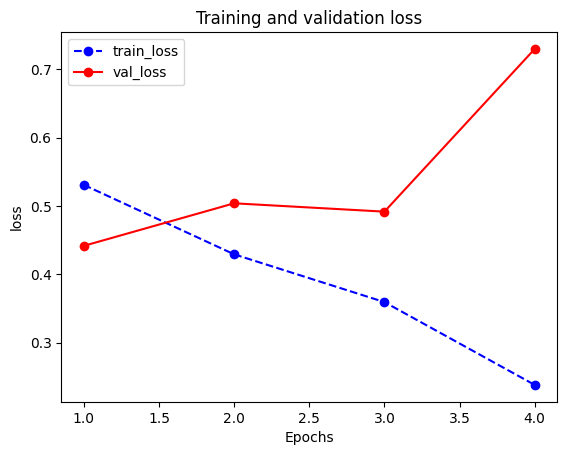

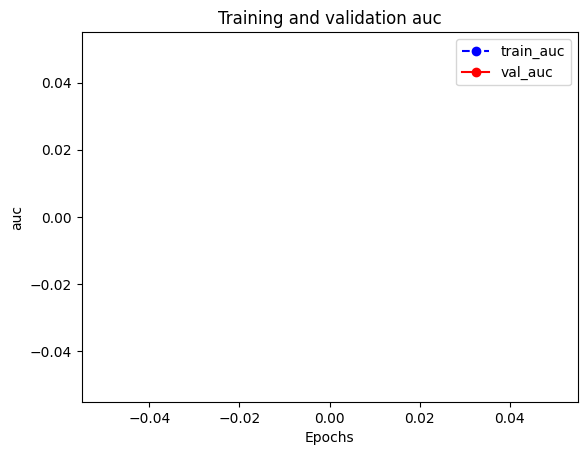

In [30]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [31]:
# 预测
y_pred_probs = net(torch.tensor(test_set.values).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [32]:
y_pred.data

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
      

In [33]:
# 模型的保存与使用
torch.save(net.state_dict(), './model/net_parameter.pkl')

In [34]:
net_clone = DeepCrossing(feature_info, hidden_units)
net_clone.load_state_dict(torch.load('./model/net_parameter.pkl'))

<All keys matched successfully>

In [35]:
y_pred_probs = net_clone(torch.tensor(test_set.values).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [36]:
y_pred

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
      